In [2]:
# from sae_core.analysis import SAEAnalyzer
from sae_core.full_analysis import SAEAnalyzer
from sae_core.pretrained import PRETRAINED_SAES, list_pretrained, load_pretrained
from sae_core.data_processing.textbook_process import load_processed_data
from transformer_lens import HookedTransformer
import numpy as np

KeyboardInterrupt: 

In [2]:
# qwen3_06B_l12_resid_file_path = list_pretrained()[-1]
qwen3_06B_l12_resid_file_path = 'qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01.physics10.exp8'
qwen3_06B_12_resid_SAE, history = load_pretrained(qwen3_06B_l12_resid_file_path, load_history=True)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
history.keys()#, history['sparsity'], history['loss']

dict_keys(['loss', 'recon_loss', 'l1_loss', 'sparsity', 'recon_contribution', 'l1_contribution', 'total_post_layer_mse', 'block_mse_contribution', '13_mse', '14_mse', '15_mse', '16_mse', '17_mse', '18_mse', '19_mse', '20_mse', '21_mse', '22_mse', '23_mse', '24_mse', '25_mse', '26_mse', '27_mse', 'logit_kl', 'kl_contribution'])

In [5]:
qwen3_06B = HookedTransformer.from_pretrained("qwen3-0.6b")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model qwen3-0.6b into HookedTransformer


In [ ]:
# chemistry_texts = load_processed_data('sae_core/data/processed_data/processed_physics_10_ch.json')
all_textbooks = load_processed_data('sae_core/data/processed_data/processed_textbooks_all.json')


In [7]:
chemistry_texts[500:510]

['# Strategy',
 'Draw a sketch. We draw the acceleration vector in the direction opposite the velocity vector because the plane is decelerating.',
 'FIGURE 2.27',
 '# Solution',
 '1. Identify the knowns.  ,  ,  .',
 '2. Identify the unknown. In this case, it is final velocity,  .',
 '3. Determine which equation to use. We can calculate the final velocity using the equation  .',
 '4. Plug in the known values and solve.',
 '# Discussion',
 'The final velocity is much less than the initial velocity, as desired when slowing down, but still positive. With jet engines, reverse thrust could be maintained long enough to stop the plane and start moving it backward. That would be indicated by a negative final velocity, which is not the case here.']

In [8]:
hook_layer = '12'
hook_name = 'hook_resid_post'
qwen3_analyzer = SAEAnalyzer(qwen3_06B, qwen3_06B_l12_resid_file_path, hook_layer, hook_name, chemistry_texts)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Loaded SAE from qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01.physics10.exp8
✓ Model and SAE on device: cuda:0
✓ Hook point: blocks.12.hook_resid_post
✓ SAE dimensions: 1024 → 8192
✓ Dataset: 4249 texts


In [9]:
qwen3_analyzer.hook_point

'blocks.12.hook_resid_post'

In [10]:
# Check:
print(f"Encoder bias mean: {qwen3_analyzer.sae.b_enc.mean()}")
print(f"Decoder bias norm: {qwen3_analyzer.sae.b_dec.norm()}")

print(f"Encoder weight mean: {qwen3_analyzer.sae.W_enc.mean()}")
print(f"Decoder weight norm: {qwen3_analyzer.sae.W_dec.norm()}")

Encoder bias mean: -0.03606902435421944
Decoder bias norm: 1.9722647666931152
Encoder weight mean: 0.000319804938044399
Decoder weight norm: 90.5096664428711


In [11]:
np.sqrt(qwen3_06B.cfg.d_model *16)

128.0

In [12]:
paragraph_lengths = [len(par) for par in chemistry_texts]
lower_quartile = np.quantile(paragraph_lengths, 0.25)
upper_quartile = np.quantile(paragraph_lengths, 0.75)
mean = np.mean(paragraph_lengths)
median = np.median(paragraph_lengths)
lower_quartile, upper_quartile, mean, median

(31.0, 343.0, 240.99882325253, 129.0)

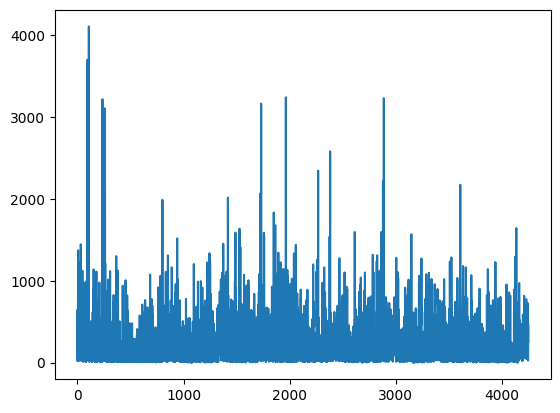

In [14]:
import matplotlib.pyplot as plt
plt.plot(paragraph_lengths)

In [15]:
large_text_list = [par for  par in chemistry_texts if len(par)>mean]
len(large_text_list)

1488

In [16]:
print(f"Dataset size: {len(large_text_list[48:64])}")
for i, text in enumerate(large_text_list[48:64]):
    print(f"Text {i}: len={len(text)}, preview={text[:50]}")

Dataset size: 16
Text 0: len=954, preview=The SI unit for length is the meter (abbreviated m
Text 1: len=992, preview=The SI unit for mass is the kilogram (abbreviated 
Text 2: len=403, preview=Electric current and its accompanying unit, the am
Text 3: len=249, preview=SI units are part of the metric system. The metric
Text 4: len=768, preview=Metric systems have the advantage that conversions
Text 5: len=595, preview=The term order of magnitude refers to the scale of
Text 6: len=506, preview=The fundamental units described in this chapter ar
Text 7: len=693, preview=The standard for length was once based on the wave
Text 8: len=969, preview=<table><tr><td rowspan=1 colspan=7>Prefix Symbol  
Text 9: len=3697, preview=<table><tr><td rowspan=1 colspan=7>Prefix Symbol  
Text 10: len=310, preview=The vastness of the universe and the breadth over 
Text 11: len=478, preview=FIGURE 1.19 Tiny phytoplankton swims among crystal
Text 12: len=410, preview=It is often necessary to convert from one 

In [18]:
# 1. Are activations centered properly?
import torch
tokens = large_text_list[0]
with torch.no_grad():
    _, cache = qwen3_06B.run_with_cache(tokens)
    acts = cache['blocks.14.hook_mlp_out']
    print(f"Activation mean: {acts.mean():.4f}")
    print(f"Activation std: {acts.std():.4f}")
    print(f"Activation range: [{acts.min():.4f}, {acts.max():.4f}]")

# 2. Check decoder norm during training
print(f"Decoder Frobenius norm: {torch.norm(qwen3_06B_12_resid_SAE.W_dec):.4f}")
print(f"Expected: {np.sqrt(qwen3_06B_12_resid_SAE.cfg.d_sae):.4f}")

# 3. Check if features are actually sparse
features = qwen3_06B_12_resid_SAE.encode(acts.flatten(0, 1).to(qwen3_06B_12_resid_SAE.device))
print(f"Feature sparsity: {(features == 0).float().mean():.4f}")  # Should be >0.9
print(f"L0 (features/token): {(features > 0).float().sum(dim=1).mean():.2f}")

Activation mean: -0.0009
Activation std: 0.4103
Activation range: [-6.8404, 7.3667]
Decoder Frobenius norm: 90.4910
Expected: 90.5097
Feature sparsity: 0.3179
L0 (features/token): 5588.09


Final epoch metrics:
  Loss: 3.1040
  Recon Loss: 0.3015
  L1 Loss: 0.0580
  Sparsity (L0): 37.09


/tmp/ipykernel_17906/3042681595.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


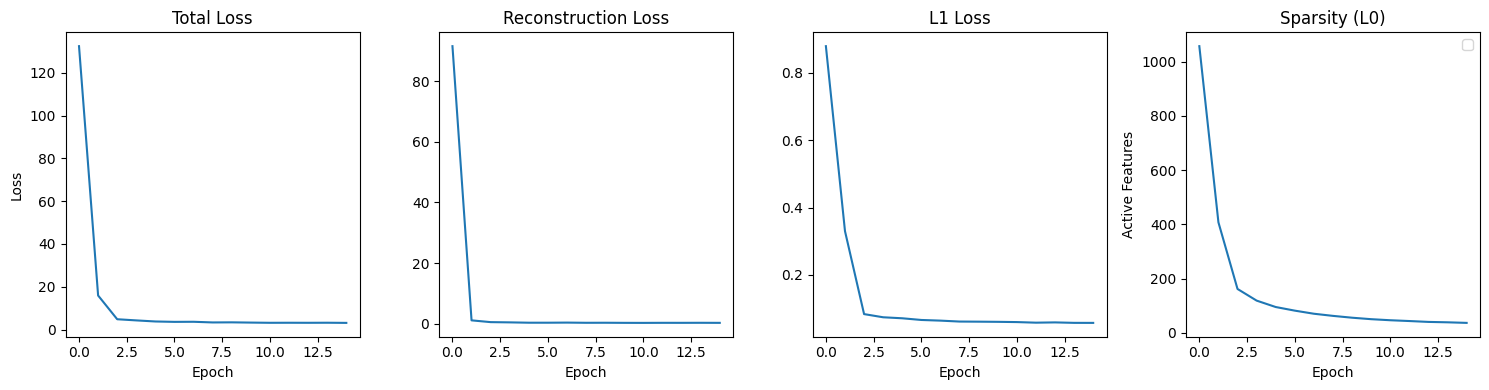

In [ ]:
import matplotlib.pyplot as plt

# Load your training history
print(f"Final epoch metrics:")
print(f"  Loss: {history['loss'][-1]:.4f}")
print(f"  Recon Loss: {history['recon_loss'][-1]:.4f}")
print(f"  L1 Loss: {history['l1_loss'][-1]:.4f}")
print(f"  Sparsity (L0): {history['sparsity'][-1]:.2f}")

# Plot training curves
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.plot(history['loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 4, 2)
plt.plot(history['recon_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 3)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 4)
plt.plot(history['sparsity'])
plt.title('Sparsity (L0)')
plt.xlabel('Epoch')
plt.ylabel('Active Features')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
analyzer = SAEAnalyzer(
    model=qwen3_06B,
    sae_path=qwen3_06B_l12_resid_file_path,
    layer=12,
    hook_name='hook_resid_post',
    dataset=chemistry_texts
)

results = analyzer.run_full_analysis(
    batch_size=16,
    save_path='analysis_results.json'
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Loaded SAE from qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01.physics10.exp8
✓ Model and SAE on device: cuda:0
✓ Hook point: blocks.12.hook_resid_post
✓ SAE dimensions: 1024 → 8192
✓ Dataset: 4249 texts

Running Full SAE Analysis


[1/4] Computing Sparsity Metrics...
Computing sparsity metrics on 4249 texts...


Sparsity: 100%|██████████| 266/266 [01:26<00:00,  3.06it/s]



✓ Sparsity Results:
  L0: 35.86 ± 74.07 features/token
  L1: 615.9682 ± 1067.1457
  Tokens processed: 891285

[2/4] Identifying Dead Features...

✓ Dead Features (threshold=0.001):
  2701/8192 (33.0%) dead features

[3/4] Computing Reconstruction Metrics...
Computing reconstruction metrics on 4249 texts...


Reconstruction: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s]



✓ Reconstruction Results:
  MSE: 0.320891
  Explained Variance: 0.9998 (99.98%)
  Cosine Similarity: 0.9529
  Tokens processed: 891285

[4/4] Running Ablation Study...
Running ablation study on 4249 texts...


Ablation: 100%|██████████| 1063/1063 [04:02<00:00,  4.39it/s]


✓ Ablation Study Results:
  Baseline Loss:      3.4088
  Zero Ablation:      11.9312 (+8.5224)
  SAE Reconstruction: 3.4667 (+0.0580)
  Loss Recovered:     99.32%
  Batches processed:  1063

✓ Results saved to analysis_results.json

Analysis Complete!



In [24]:
results.keys()

dict_keys(['sparsity', 'feature_freq', 'dead_features', 'reconstruction', 'ablation'])

Dead features: [8, 17, 21, 29, 37, 39, 41, 42, 43, 46, 49, 51, 52, 55, 58, 59, 64, 65, 66, 70]...
Active features: 5491

Feature Activity Distribution:
  dead        :  2701 (32.97%)
  rare        :  4995 (60.97%)
  common      :   466 ( 5.69%)
  frequent    :    28 ( 0.34%)
  super_active:     2 ( 0.02%)


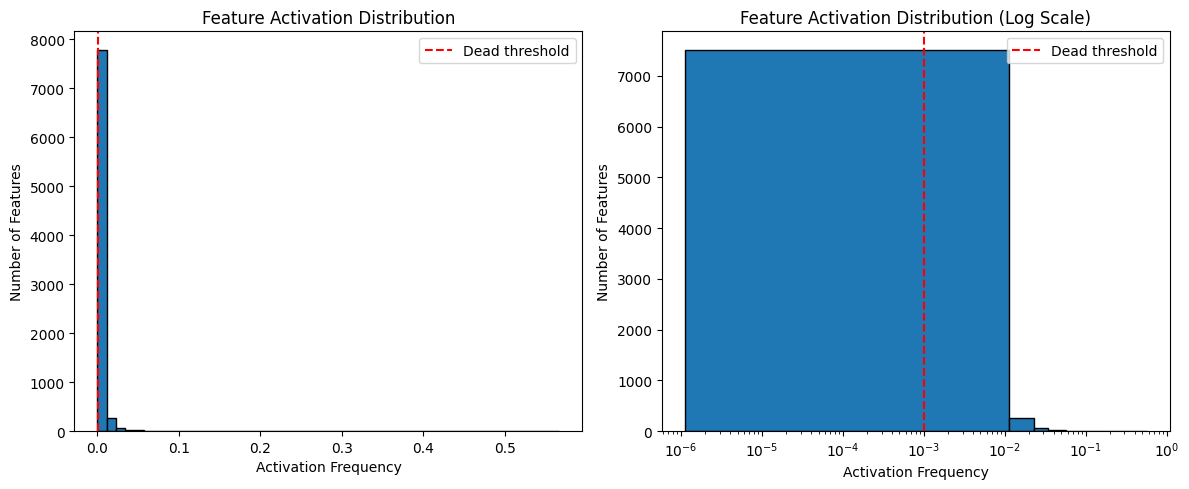


Top 10 Most Active Features:
  1. Feature 7227: 0.5668 (56.68% of tokens)
  2. Feature 7304: 0.5116 (51.16% of tokens)
  3. Feature 2842: 0.4787 (47.87% of tokens)
  4. Feature 3853: 0.4501 (45.01% of tokens)
  5. Feature  831: 0.4434 (44.34% of tokens)
  6. Feature  332: 0.4237 (42.37% of tokens)
  7. Feature 3404: 0.3499 (34.99% of tokens)
  8. Feature  383: 0.3299 (32.99% of tokens)
  9. Feature 4053: 0.3290 (32.90% of tokens)
  10. Feature 5308: 0.3085 (30.85% of tokens)

Top 10 Least Active (but not dead) Features:
  1. Feature 7243: 0.000001 (0.0001% of tokens)
  2. Feature 7394: 0.000001 (0.0001% of tokens)
  3. Feature 7411: 0.000001 (0.0001% of tokens)
  4. Feature 7431: 0.000001 (0.0001% of tokens)
  5. Feature 7480: 0.000001 (0.0001% of tokens)
  6. Feature 7677: 0.000001 (0.0001% of tokens)
  7. Feature 7895: 0.000001 (0.0001% of tokens)
  8. Feature 7937: 0.000001 (0.0001% of tokens)
  9. Feature 7963: 0.000001 (0.0001% of tokens)
  10. Feature 8099: 0.000001 (0.0001% of 

In [26]:
feature_freq = results['feature_freq']
dead_features = results['dead_features']
dead_indices = dead_features['dead_indices']
print(f"Dead features: {dead_indices[:20]}...")

active_indices = [i for i in range(len(feature_freq)) if i not in dead_indices]
print(f"Active features: {len(active_indices)}")

feature_freq_array = np.array(feature_freq)

# Categorize features by activity level
categories = {
    'dead': (feature_freq_array < 0.001).sum(),
    'rare': ((feature_freq_array >= 0.001) & (feature_freq_array < 0.01)).sum(),
    'common': ((feature_freq_array >= 0.01) & (feature_freq_array < 0.1)).sum(),
    'frequent': ((feature_freq_array >= 0.1) & (feature_freq_array < 0.5)).sum(),
    'super_active': (feature_freq_array >= 0.5).sum()
}

print("\nFeature Activity Distribution:")
for cat, count in categories.items():
    pct = 100 * count / len(feature_freq)
    print(f"  {cat:12s}: {count:5d} ({pct:5.2f}%)")


plt.figure(figsize=(12, 5))
# Linear scale
plt.subplot(1, 2, 1)
plt.hist(feature_freq_array, bins=50, edgecolor='black')
plt.xlabel('Activation Frequency')
plt.ylabel('Number of Features')
plt.title('Feature Activation Distribution')
plt.axvline(0.001, color='red', linestyle='--', label='Dead threshold')
plt.legend()

# Log scale
plt.subplot(1, 2, 2)
plt.hist(feature_freq_array[feature_freq_array > 0], bins=50, edgecolor='black')
plt.xlabel('Activation Frequency')
plt.ylabel('Number of Features')
plt.title('Feature Activation Distribution (Log Scale)')
plt.xscale('log')
plt.axvline(0.001, color='red', linestyle='--', label='Dead threshold')
plt.legend()

plt.tight_layout()
plt.savefig('feature_activity_distribution.png', dpi=150)
plt.show()

# Find most and least active features
active_freq = [(i, freq) for i, freq in enumerate(feature_freq) if freq > 0]
active_freq.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 Most Active Features:")
for i, (feat_idx, freq) in enumerate(active_freq[:10]):
    print(f"  {i+1}. Feature {feat_idx:4d}: {freq:.4f} ({freq*100:.2f}% of tokens)")

print("\nTop 10 Least Active (but not dead) Features:")
for i, (feat_idx, freq) in enumerate(active_freq[-10:]):
    print(f"  {i+1}. Feature {feat_idx:4d}: {freq:.6f} ({freq*100:.4f}% of tokens)")

In [27]:
activation_db = analyzer.collect_all_activations(
    batch_size=16,
    activation_threshold=0.0,
    save_path="activation_db.pkl" 
)    
print(f"\nDatabase built!")
print(f"  Total tokens: {len(activation_db.token_metadata)}")
print(f"  Features: {activation_db.activation_matrix.shape[1]}")
print(f"  Sparsity: {activation_db.feature_metadata['sparsity']*100:.2f}%")


This will build a comprehensive activation database.



Processing: 100%|██████████| 266/266 [37:36<00:00,  8.48s/it] 



✓ Processed 891285 tokens
✓ Collected 31964301 non-zero activations

Building sparse activation matrix...
✓ Matrix shape: (891285, 8192)
✓ Sparsity: 99.56% (zeros)
Building feature activation index...


Indexing: 100%|██████████| 31964301/31964301 [00:14<00:00, 2195670.99it/s]


✓ Saved activation database to activation_db.pkl

Database built!
  Total tokens: 891285
  Features: 8192
  Sparsity: 99.56%


In [28]:
print("\nComputing feature similarity...")
similarity_matrix = analyzer.compute_feature_similarity(
    save_path="feature_similarity.npy",
    similarity_metric='cosine'  # or 'dot', 'euclidean'
)

print(f"Similarity matrix computed: {similarity_matrix.shape}")


Computing feature similarity...

Computing feature similarity using cosine metric...
✓ Computed 8192 × 8192 similarity matrix
  Mean similarity: 0.0034
  Std similarity: 0.0373
✓ Saved similarity matrix to feature_similarity.npy
Similarity matrix computed: (8192, 8192)


In [43]:
feature_idx = 1000

analyzer.analyze_feature_with_context(
    feature_idx=feature_idx,
    top_k=10, 
    context_size=10  # 10 tokens before/after
)


Feature 1000 Analysis

Activation Statistics:
  Frequency: 181.0 tokens (0.02%)
  Mean activation: 0.2585

Top 10 Activating Examples:
------------------------------------------------------------

1. Activation: 1.6303
   Token: ' to'
   Context:  H ubble  constant  for  universal  expansion  and  the  time  back  to  the  Big  Bang  are  determined ,  respectively . <|endoftext|> <|endoftext|>

2. Activation: 1.4709
   Token: ' to'
   Context:  quickly ,  saving  lives  and  enabling  a  more  swift  return  to  economic  operations .  And  as  critical  emerging  information  infrastructure ,

3. Activation: 1.4206
   Token: ' to'
   Context:  the  cg  of  a  female  is  lower  ( clo ser  to  the  ground )  than  a  male .  Young  children  have

4. Activation: 1.2592
   Token: ' to'
   Context:  wind ,  explain  why  the  smaller  angle  ( clo ser  to  the  horizontal )  is  preferable .  When  would  it  be

5. Activation: 1.2015
   Token: ' to'
   Context: -being  with  radiation

In [44]:
# Query DB directly
print(f"\nQuerying feature {feature_idx}...")
activations = activation_db.get_feature_activations(feature_idx, top_k=5)

for token_idx, act_val in activations:
    context = activation_db.get_token_context(token_idx, qwen3_06B, context_size=5)
    print(f"\nActivation: {act_val:.4f}")
    print(f"Token: '{context['token']}'")
    print(f"Context: {context['context']}")


Querying feature 1000...



Activation: 1.6303
Token: ' to'
Context:  expansion  and  the  time  back  to  the  Big  Bang  are  determined

Activation: 1.4709
Token: ' to'
Context:  enabling  a  more  swift  return  to  economic  operations .  And  as

Activation: 1.4206
Token: ' to'
Context:  is  lower  ( clo ser  to  the  ground )  than  a

Activation: 1.2592
Token: ' to'
Context:  smaller  angle  ( clo ser  to  the  horizontal )  is  preferable

Activation: 1.2015
Token: ' to'
Context:  She  is  the  only  person  to  win  Nobel  prizes  in  both


In [46]:
similar_features = analyzer.find_similar_features(
    feature_idx=feature_idx,
    top_k=5
)

print(f"\nFeatures most similar to feature {feature_idx}:")
for sim_idx, similarity in similar_features:
    print(f"  Feature {sim_idx}: similarity = {similarity:.4f}")
    
    # Show an example activation for this similar feature
    sim_acts = activation_db.get_feature_activations(sim_idx, top_k=1)
    if sim_acts:
        token_idx, act_val = sim_acts[0]
        context = activation_db.get_token_context(token_idx, qwen3_06B, context_size=3)
        print(f"    Example: '{context['token']}' (activation: {act_val:.4f})")


Features most similar to feature 1000:
  Feature 6205: similarity = 0.2774
    Example: ' memor' (activation: 0.8269)
  Feature 105: similarity = 0.2410
    Example: 'Lead' (activation: 0.0642)
  Feature 1747: similarity = 0.2176
    Example: 'ephy' (activation: 3.3152)
  Feature 1041: similarity = 0.2010
    Example: ' thumb' (activation: 1.5135)
  Feature 5754: similarity = 0.2001
    Example: ' young' (activation: 1.0008)


In [ ]:
examples = analyzer.find_max_activating_examples(feature_idx=100, top_k=10)

In [23]:
examples

[{'text': '<|im_end|>The ballistocardiograph (BCG) was a diagnostic tool used',
  'target_token': 'ardi',
  'activation': 14.561932563781738,
  'position': 5,
  'batch_idx': 1100},
 {'text': ' due to heart beats is the “ballistocardiograph.” What physics principle(s) are involved here',
  'target_token': 'ardi',
  'activation': 12.59427261352539,
  'position': 95,
  'batch_idx': 579},
 {'text': 'recall Newton’s third law). A ballistocardiograph is a device that can measure this reaction force',
  'target_token': 'ardi',
  'activation': 12.298065185546875,
  'position': 77,
  'batch_idx': 1100},
 {'text': ' blood passing from the heart. However, the electrocardiogram (ECG or EKG) and',
  'target_token': 'card',
  'activation': 11.177844047546387,
  'position': 141,
  'batch_idx': 1100},
 {'text': ' (inversely) on the diameter of the axon (nerve fiber). If the nerve cell',
  'target_token': ' ax',
  'activation': 9.841863632202148,
  'position': 32,
  'batch_idx': 248},
 {'text': ' passi

In [19]:
results.keys()

dict_keys(['sparsity', 'feature_freq', 'dead_features', 'reconstruction', 'ablation'])

In [20]:
results['sparsity']

{'l0_mean': 71.19680767680387,
 'l0_std': 189.16221470510405,
 'l1_mean': 141.15328702705804,
 'l1_std': 473.4737452056373,
 'n_features': 8192,
 'n_tokens': 357232}

In [21]:
results['ablation']

{'baseline_loss': 2.773143518355585,
 'zero_ablation_loss': 11.931214499217207,
 'sae_reconstruction_loss': 2.922223191748383,
 'loss_recovered': 0.9837214983696521,
 'n_batches': 372}

In [22]:
qwen3_06B.cfg.d_model

1024